寻找赔钱的操作！
MA60 的斜率

In [1]:
from analysis_utils import *
from utils import date_to_milliseconds
pd.set_option('display.max_columns', None)

<Figure size 1000x500 with 0 Axes>

In [2]:
usd_name = 'TUSD'
token_name = 'BTC'
is_futures = False
symbol = token_name + usd_name
sim_data = get_combined_data(symbol, 'SellAfter2Step-TH2', 1682655420000, 1692364319999, is_futures, confirm_step=2)
sim_data_info = read_data(symbol, 'SellAfter2Step-TH2', 1682655420000, 1692364319999, is_futures)
print(f"data length = {len(sim_data)}")

buy_p    = sim_data_info.buy_points
sell_p   = sim_data_info.sell_points

sim_data['buy_price'] = np.nan
sim_data['sell_price'] = np.nan

j = 0
fee = 0.00002
for i in range(len(sim_data)):
    if sim_data['open_time'][i] == buy_p.idx[j]:
        # Record these info on the preview step of the actually traded step
        curr_idx: int = sim_data.index[i]  # type: ignore
        pre_idx = curr_idx - 1

        sim_data.loc[pre_idx, 'buy_price'] = buy_p.value[j]
        sim_data.loc[pre_idx, 'hold_step'] = (sell_p.idx[j] - buy_p.idx[j]) // 60000
        sim_data.loc[pre_idx, 'sell_price'] = sell_p.value[j]
        sim_data.loc[pre_idx, 'earn'] = (sell_p.value[j] - buy_p.value[j]) / buy_p.value[j] - 2 * fee

        if sim_data.loc[pre_idx, 'is_up'] == 0:  
            # bottom is not confirmed.
            top_idx = pre_idx - sim_data.loc[pre_idx, 'step_after_top'] # type: ignore
            i_min = int(np.argmin(sim_data.loc[top_idx: pre_idx, 'low']))

            lowest = np.inf
            i_min = pre_idx - top_idx
            lows = lambda i: sim_data.loc[top_idx + i, 'low'] 
            for i in range(0, int(pre_idx - top_idx + 1)):
                if lows(i) < lows(i-1) and lows(i) < lowest:    # type: ignore
                    lowest = lows(i)
                    i_min = i
            
            sim_data.loc[pre_idx, 'last_bottom'] = sim_data.loc[top_idx + i_min, 'low']
            sim_data.loc[pre_idx, 'step_after_bottom'] = pre_idx - top_idx - i_min
            sim_data.loc[pre_idx, 'cycle_step'] = i_min
        
        j += 1
        if j >= len(sell_p.idx):
            break

# sim_data[sim_data['buy_price'].isnull() == False].head()

data length = 161815


In [3]:
# sim_data[sim_data['buy_price'].isnull() == False].head()
# sim_data.loc[8561-5 : 8561+5]
# sim_data.head(10)

In [4]:
total_num = sum(sim_data['buy_price'].isnull() == False)
print(f"Total: {total_num}")
earn_num = sum(sim_data['earn'] > 0)
print(f"Earn rate: {earn_num / total_num * 100 :.2f}%")
print(f"Average earn: {sim_data[sim_data['buy_price'].isnull() == False]['earn'].mean() * 100 :.4f}%")

Total: 11314
Earn rate: 43.85%
Average earn: -0.0008%


In [5]:
target = Target(target_step=3, steps=[3])
full_data = FeatData(sim_data, target)

# Drop useless features
full_data.drop_features(
   ['close_time', 'volume', 'taker_buy_volume', 'open_time', 'buy_price', 'sell_price'])

full_data.set_features_type(['hold_step'], FeatTypes.OTHERS)
full_data.set_features_type(['earn'], FeatTypes.TARGET)
full_data.add_feature('is_earn', FeatTypes.TARGET, lambda df: df['earn'].apply(lambda x: 1 if x > 0 else 0))

# full_data.add_feature('max_after_top', FeatTypes.TARGET, lambda df: 
#                       (df['high'].rolling(3).max().shift(-3) - df['last_top']) / df['close']) # / df['close']  
# full_data.add_feature('min_after_top', FeatTypes.TARGET, lambda df: 
#                       (df['low'].rolling(2).min().shift(-3) - df['last_top']) / df['close'])  

full_data.add_feature('TR', FeatTypes.TR, lambda df: df['high'] - df['low'] + 0.000001)   # Incase TR is 0
full_data.add_feature('ER', FeatTypes.OTHERS, lambda df: (df['close'] - df['close'].shift(1)) / df['TR'])
full_data.add_feature('ERabs', FeatTypes.OTHERS, lambda df: df['ER'].abs())

full_data.add_feature('2step_inc', FeatTypes.DPRICE, lambda df: df['last_top'] - df['close'].shift(1))
full_data.add_feature('top-bottom/step', FeatTypes.DPRICE, lambda df: 
                      (df['last_top'] - df['last_bottom']) / (1 + df['step_after_bottom']))

full_data.add_feature('btm_step/top_step', FeatTypes.OTHERS, lambda df: df['step_after_bottom'] / df['step_after_top'])

# Add last last top and bottom
def add_last_tb(df: DataFrame):
    last_top = np.nan
    last_bottom = np.nan
    ll_top = np.nan
    ll_bottom = np.nan

    def fun(x):
        nonlocal ll_top, ll_bottom, last_top, last_bottom
        if x['last_top'] != last_top:
            ll_top = last_top
            last_top = x['last_top']
        
        if x['last_bottom'] != last_bottom:
            ll_bottom = last_bottom
            last_bottom = x['last_bottom']

        return ll_top, ll_bottom

    return df.apply(
            lambda x: fun(x), axis=1, result_type="expand")  # type: ignore

full_data.add_features(['ll_top', 'll_bottom'], [FeatTypes.PRICE, FeatTypes.PRICE], add_last_tb)
full_data.add_feature('ll_l_top', FeatTypes.DPRICE, lambda df: df['ll_top'] - df['last_top'])
full_data.add_feature('ll_l_bottom', FeatTypes.DPRICE, lambda df: df['ll_bottom'] - df['last_bottom'])

full_data.add_feature('high', FeatTypes.DPRICE, lambda df: df['high'] - df['close'])
full_data.add_feature('low', FeatTypes.DPRICE, lambda df: df['low'] - df['close'])
full_data.add_feature('open', FeatTypes.DPRICE, lambda df: df['open'] - df['close'])

# 单位波动的成交额 -> 无效
# full_data.add_feature('volume/TR', FeatTypes.VOL_TR, lambda df: df['quote_assert_volume'] * df['close'] / df['TR'])
add_ave_features(full_data, cycles = [60], feat_names=['quote_assert_volume'])
full_data.add_feature('E/V', FeatTypes.DPRICE, lambda df: 
                      (df['close'] - df['close'].shift(1)) / (df['quote_assert_volume'] / df['AQAV60']))
full_data.drop_features(['quote_assert_volume', 'taker_buy_quote_asset_volume', 'AQAV60'])

# Add features
add_ave_features(full_data, cycles = [3, 10, 60], feat_names=['close', 'TR'])
add_ave_features(full_data, cycles = [3, 11, 21, 60], feat_names=['ER'], new_ave_of_base={'AER': ['ER', FeatTypes.OTHERS]})
add_ave_features(full_data, cycles = [3, 11, 21, 60], feat_names=['ERabs'], new_ave_of_base={'AERabs': ['ERabs', FeatTypes.OTHERS]})
# self.add_feature(name, ftype, lambda df: df[base_name].rolling(cc).mean())
full_data.add_feature('ATRstd60', FeatTypes.OTHERS, lambda df: df['TR'].rolling(60).std() / df['ATR60'])
full_data.add_feature('ATRstd20', FeatTypes.OTHERS, lambda df: df['TR'].rolling(20).std() / df['ATR60'])

full_data.add_feature('std10', FeatTypes.DPRICE, lambda df: (df['close'] - df['MA10']).rolling(10).mean())
full_data.add_feature('std60', FeatTypes.DPRICE, lambda df: (df['close'] - df['MA10']).rolling(60).mean())
full_data.add_feature('std10abs10', FeatTypes.DPRICE, lambda df: (df['close'] - df['MA10']).abs().rolling(10).mean())
full_data.add_feature('std10abs60', FeatTypes.DPRICE, lambda df: (df['close'] - df['MA10']).abs().rolling(60).mean())
full_data.add_feature('MA10_inc10', FeatTypes.DPRICE, lambda df: df['MA10'] - df['MA10'].shift(10))
full_data.add_feature('MA60_inc10', FeatTypes.DPRICE, lambda df: df['MA60'] - df['MA60'].shift(10))


# fast_period = 10 
# slow_period = 60
# signal_period = 30
# add_macd(full_data, 'close', FeatTypes.DPRICE)
# add_macd(full_data, 'ER', FeatTypes.OTHERS)

# Standardization
full_data.std()

# Drop na at last
full_data.drop_na()

full_data.df.head()

,open,high,low,close,TR,step_after_top,last_bottom,step_after_bottom,is_up,cycle_step,hold_step,earn,earn_after_3,is_earn,ER,ERabs,2step_inc,top-bottom/step,btm_step/top_step,ll_top,ll_bottom,ll_l_top,ll_l_bottom,E/V,MA3,MA10,MA60,ATR3,ATR10,ATR60,AER3,AER11,AER21,AER60,AERabs3,AERabs11,AERabs21,AERabs60,ATRstd60,ATRstd20,std10,std60,std10abs10,std10abs60,MA10_inc10,MA60_inc10
78,-0.000204,0.000116,-0.000552,0.999258,0.000668,5.0,0.998706,0.0,0.0,5.0,2.0,0.001107,0.002274,1,0.382979,0.382979,0.000998,0.001294,0.000000,1.000526,0.999293,0.000526,0.000587,0.000173,0.999185,0.999541,0.999606,0.000485,0.000459,0.000545,-0.223921,-0.232628,-0.075777,-0.034955,0.479240,0.408278,0.397231,0.401913,0.406636,0.258277,-0.000367,-0.000008,0.000367,0.000336,-0.000603,0.000015
88,-0.000045,0.000074,-0.000625,0.999826,0.000699,2.0,0.999187,2.0,0.0,0.0,2.0,0.000319,-0.000350,1,0.000000,0.000000,0.000174,0.000271,1.000000,1.000291,0.999171,0.000291,-0.000015,0.000000,0.999842,0.999656,0.998473,0.000638,0.000806,0.000587,0.165177,0.125851,-0.074168,-0.028427,0.248511,0.429566,0.420634,0.426792,0.451387,0.540105,0.000792,0.000127,0.000792,0.000447,0.001511,0.000264
117,0.000083,0.000136,-0.000211,0.999532,0.000346,4.0,0.999227,4.0,0.0,0.0,2.0,0.000237,0.000366,1,-0.231672,0.231672,0.000388,0.000155,1.000000,1.000612,0.998769,0.000612,-0.000458,-0.000199,0.999621,0.999463,1.000135,0.000357,0.000511,0.000567,-0.048872,0.033659,-0.075826,-0.062752,0.315539,0.396438,0.335510,0.393841,0.424605,0.240915,0.000120,0.000015,0.000254,0.000485,-0.000072,0.000014
142,0.000190,0.000223,-0.000264,0.999220,0.000487,13.0,0.997879,7.0,1.0,6.0,2.0,-0.000353,0.000354,0,-0.356050,0.356050,0.000606,0.000265,0.538462,1.002038,0.997943,0.002038,0.000065,-0.000269,0.999208,0.998837,1.000511,0.000719,0.000702,0.000635,-0.209874,-0.086977,-0.118692,-0.096966,0.408530,0.397587,0.399793,0.389897,0.404975,0.500148,-0.000120,-0.000206,0.000417,0.000482,-0.000384,-0.000421
158,0.000193,0.000309,-0.000039,0.999582,0.000348,3.0,0.999340,1.0,0.0,2.0,2.0,0.000081,0.000964,1,-0.556098,0.556098,0.000225,0.000330,0.333333,1.000485,0.999435,0.000485,0.000095,-0.000459,0.999719,0.999773,1.000102,0.000477,0.000591,0.000658,-0.075496,0.029053,-0.014676,-0.072761,0.324272,0.369144,0.406133,0.390270,0.401004,0.438304,0.000074,-0.000156,0.000130,0.000410,0.000160,-0.000390


In [6]:
price_feats  = set(full_data.cols_of_features([FeatTypes.PRICE]))
dprice_feats = set(full_data.cols_of_features([FeatTypes.DPRICE]))
tr_feats     = set(full_data.cols_of_features([FeatTypes.TR]))
vol_feats    = set(full_data.cols_of_features([FeatTypes.VOLUME]))
voltr_feats  = set(full_data.cols_of_features([FeatTypes.VOL_TR]))
tn_feats     = set(full_data.cols_of_features([FeatTypes.TRADE_NUM]))
print(f"price_feats: {price_feats}\n\
        dprice_feats: {dprice_feats}\n\
        tr_feats: {tr_feats}\n\
        vol_feats: {vol_feats}\n\
        voltr_feats: {voltr_feats}\n\
        tn_feats: {tn_feats}")
print(f"{set(full_data.df.columns) - price_feats - dprice_feats - tr_feats - vol_feats - tn_feats}")

price_feats: {'ll_top', 'MA3', 'MA60', 'last_bottom', 'close', 'll_bottom', 'MA10'}
        dprice_feats: {'open', 'E/V', '2step_inc', 'std10abs60', 'std10abs10', 'MA10_inc10', 'll_l_bottom', 'std60', 'll_l_top', 'std10', 'high', 'top-bottom/step', 'low', 'MA60_inc10'}
        tr_feats: {'TR', 'ATR10', 'ATR3', 'ATR60'}
        vol_feats: set()
        voltr_feats: set()
        tn_feats: set()
{'step_after_top', 'cycle_step', 'step_after_bottom', 'AER3', 'ER', 'AERabs60', 'AER21', 'hold_step', 'is_earn', 'AER11', 'earn_after_3', 'ATRstd20', 'earn', 'AERabs11', 'AERabs21', 'ERabs', 'btm_step/top_step', 'is_up', 'AERabs3', 'AER60', 'ATRstd60'}


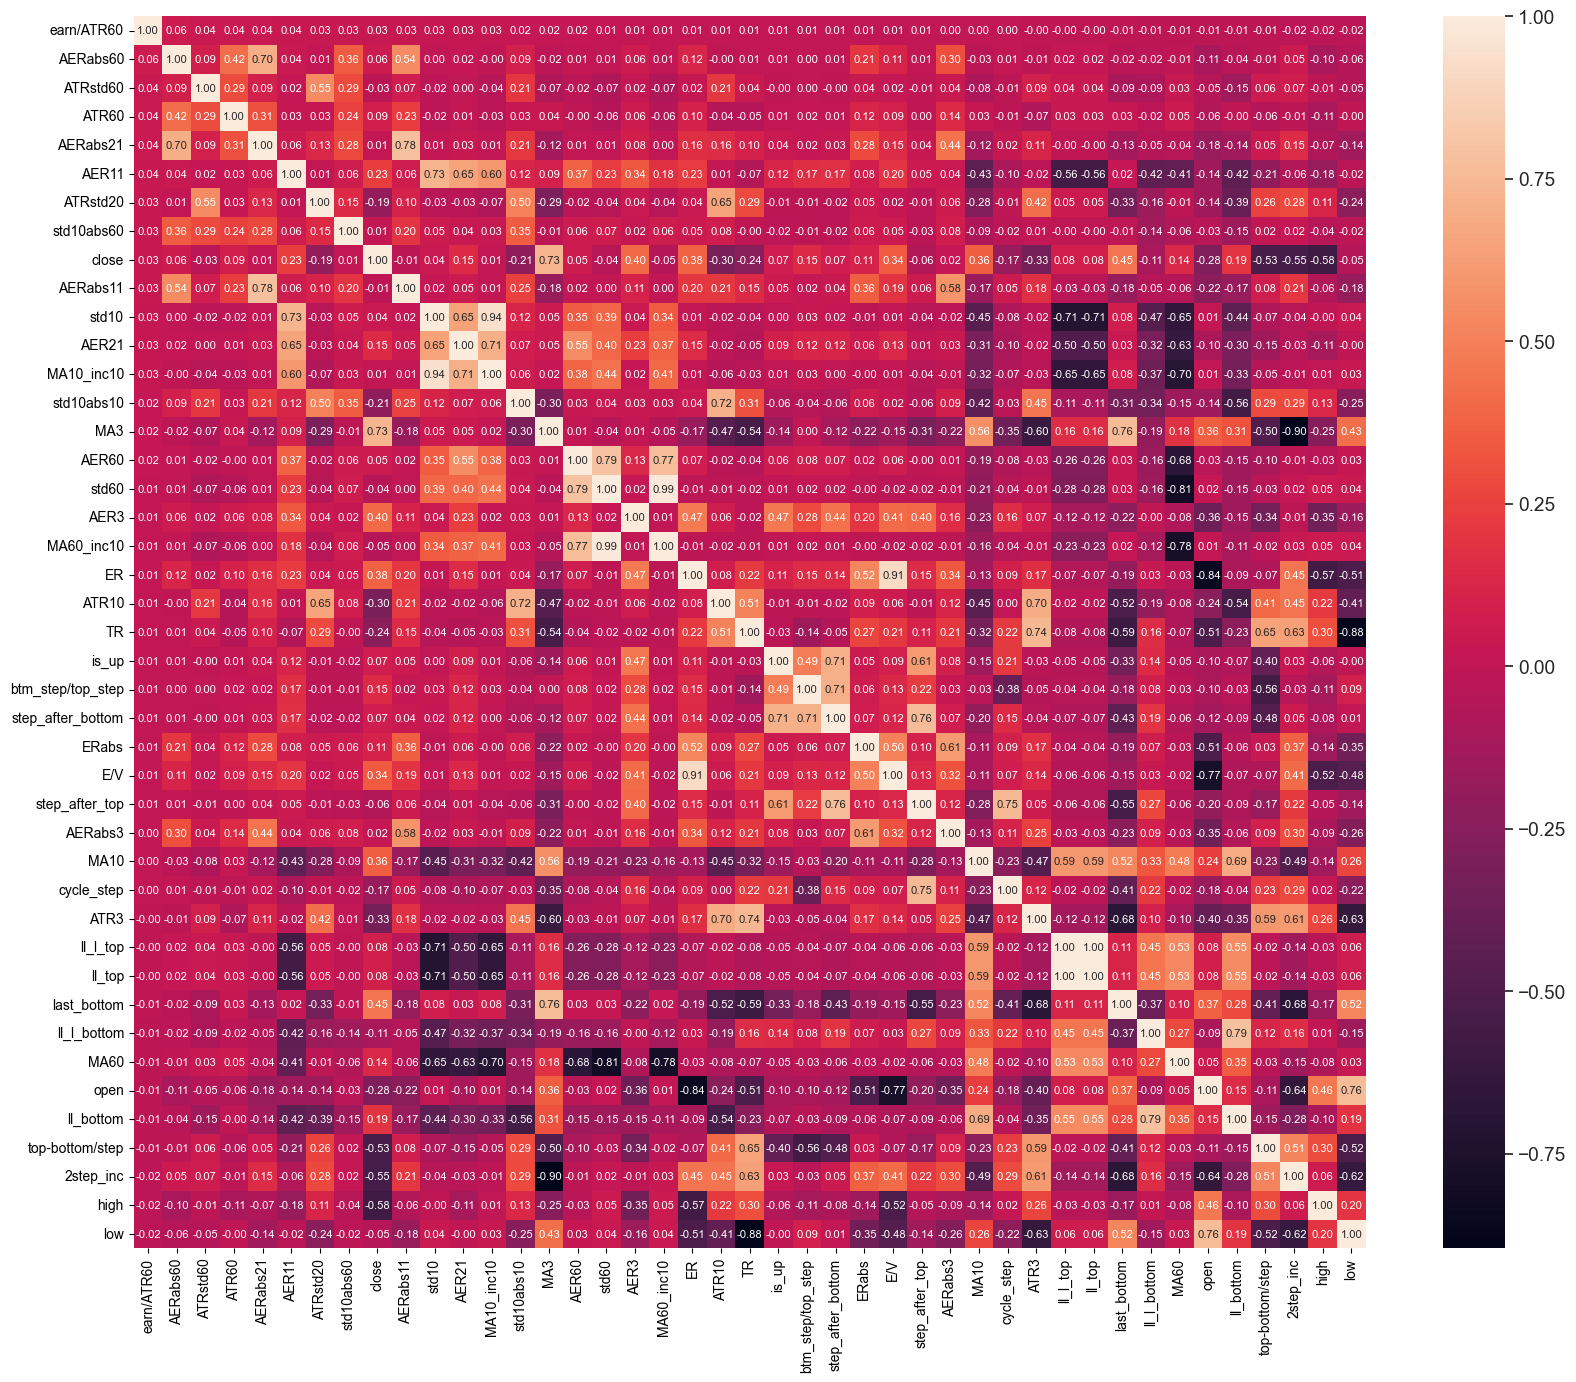

In [7]:
heatmap_data = full_data.df.iloc[:, :].copy()

target.reset_target(3)
target.drop_others(heatmap_data)
heatmap_data[target.target_name()] = heatmap_data[target.target_name()] / heatmap_data['ATR60']
drop_col(heatmap_data, [target.target_name()])
drop_col(heatmap_data, ['hold_step'])

base_atr = 'ATR60'

heatmap_data['earn/ATR60'] = heatmap_data['earn'] / heatmap_data['ATR60']

# heatmap_data['max_after_top'] = heatmap_data['max_after_top'] / heatmap_data[base_atr]
# heatmap_data['min_after_top'] = heatmap_data['min_after_top'] / heatmap_data[base_atr]


# outlire_value = 10
# outlire_idx = heatmap_data[heatmap_data['max_after_top'] > outlire_value].index
# heatmap_data.loc[outlire_idx, 'max_after_top'] = outlire_value

for feat in price_feats:
    heatmap_data[feat] = (heatmap_data[feat] - 1) / heatmap_data[base_atr]

for feat in dprice_feats:
    heatmap_data[feat] = heatmap_data[feat] / heatmap_data[base_atr]

for feat in (tr_feats - {base_atr}):
    heatmap_data[feat] = heatmap_data[feat] / heatmap_data[base_atr]

# for feat in (vol_feats - {'AQAV60'}):
#     heatmap_data[feat] = heatmap_data[feat] / heatmap_data['AQAV60']

# for feat in (voltr_feats - {'AVT60'}):
#     heatmap_data[feat] = heatmap_data[feat] / heatmap_data['AVT60']
    
# for feat in (tn_feats - {'AT60'}):
#     heatmap_data[feat] = heatmap_data[feat] / heatmap_data['AT60']


# heatmap_data['ll_top'] = heatmap_data['ll_top'] - heatmap_data['last_top']
# heatmap_data['ll_bottom'] = heatmap_data['ll_bottom'] - heatmap_data['last_bottom']

heatmap_data.replace([np.inf, -np.inf], np.nan, inplace=True)
heatmap_data.dropna(axis=0, how='any', inplace=True)

# drop_col(heatmap_data, price_feats - {max_100, min_100})
# drop_col(heatmap_data, dprice_feats)
# drop_col(heatmap_data, tr_feats)
drop_col(heatmap_data, tn_feats)
# drop_col(heatmap_data, vol_feats)
# drop_col(heatmap_data, set(full_data.cols_of_features([FeatTypes.OTHERS])))

# heatmap_data['ave_after_top'] = (heatmap_data['max_after_top'] + heatmap_data['min_after_top']) / 2
target_name = 'earn/ATR60'
# max_loss_idx = heatmap_data[heatmap_data['earn/ATR60'] < -0.5001].index
# print(len(max_loss_idx))

cols = [c for c in heatmap_data.columns if c not in ['earn', 'is_earn', 'max_after_top', 'min_after_top']]
heatmap_font(heatmap_data.iloc[:, :].loc[:, cols], target=target_name)

up_idx = heatmap_data[heatmap_data['is_up'] == 1].index
down_idx = heatmap_data[heatmap_data['is_up'] == 0].index
# drop_col(heatmap_data, ['is_up'])

In [8]:
# up_loss_idx = [idx for idx in max_loss_idx if idx in up_idx]
# print(len(up_loss_idx))
# heatmap_font(heatmap_data.loc[up_idx, :], target=target_name)
# heatmap_data.loc[up_loss_idx].head()

In [9]:
# down_loss_idx = [idx for idx in max_loss_idx if idx in down_idx]
# print(len(down_loss_idx))
# heatmap_font(heatmap_data.loc[down_idx, :], target=target_name)
# heatmap_data.loc[down_loss_idx].head()

In [10]:
full_data.df.head(10)

,open,high,low,close,TR,step_after_top,last_bottom,step_after_bottom,is_up,cycle_step,hold_step,earn,earn_after_3,is_earn,ER,ERabs,2step_inc,top-bottom/step,btm_step/top_step,ll_top,ll_bottom,ll_l_top,ll_l_bottom,E/V,MA3,MA10,MA60,ATR3,ATR10,ATR60,AER3,AER11,AER21,AER60,AERabs3,AERabs11,AERabs21,AERabs60,ATRstd60,ATRstd20,std10,std60,std10abs10,std10abs60,MA10_inc10,MA60_inc10
78,-0.000204,0.000116,-0.000552,0.999258,0.000668,5.0,0.998706,0.0,0.0,5.0,2.0,0.001107,0.002274,1,0.382979,0.382979,0.000998,0.001294,0.000000,1.000526,0.999293,0.000526,0.000587,0.000173,0.999185,0.999541,0.999606,0.000485,0.000459,0.000545,-0.223921,-0.232628,-0.075777,-0.034955,0.479240,0.408278,0.397231,0.401913,0.406636,0.258277,-0.000367,-0.000008,0.000367,0.000336,-0.000603,0.000015
88,-0.000045,0.000074,-0.000625,0.999826,0.000699,2.0,0.999187,2.0,0.0,0.0,2.0,0.000319,-0.000350,1,0.000000,0.000000,0.000174,0.000271,1.000000,1.000291,0.999171,0.000291,-0.000015,0.000000,0.999842,0.999656,0.998473,0.000638,0.000806,0.000587,0.165177,0.125851,-0.074168,-0.028427,0.248511,0.429566,0.420634,0.426792,0.451387,0.540105,0.000792,0.000127,0.000792,0.000447,0.001511,0.000264
117,0.000083,0.000136,-0.000211,0.999532,0.000346,4.0,0.999227,4.0,0.0,0.0,2.0,0.000237,0.000366,1,-0.231672,0.231672,0.000388,0.000155,1.000000,1.000612,0.998769,0.000612,-0.000458,-0.000199,0.999621,0.999463,1.000135,0.000357,0.000511,0.000567,-0.048872,0.033659,-0.075826,-0.062752,0.315539,0.396438,0.335510,0.393841,0.424605,0.240915,0.000120,0.000015,0.000254,0.000485,-0.000072,0.000014
142,0.000190,0.000223,-0.000264,0.999220,0.000487,13.0,0.997879,7.0,1.0,6.0,2.0,-0.000353,0.000354,0,-0.356050,0.356050,0.000606,0.000265,0.538462,1.002038,0.997943,0.002038,0.000065,-0.000269,0.999208,0.998837,1.000511,0.000719,0.000702,0.000635,-0.209874,-0.086977,-0.118692,-0.096966,0.408530,0.397587,0.399793,0.389897,0.404975,0.500148,-0.000120,-0.000206,0.000417,0.000482,-0.000384,-0.000421
158,0.000193,0.000309,-0.000039,0.999582,0.000348,3.0,0.999340,1.0,0.0,2.0,2.0,0.000081,0.000964,1,-0.556098,0.556098,0.000225,0.000330,0.333333,1.000485,0.999435,0.000485,0.000095,-0.000459,0.999719,0.999773,1.000102,0.000477,0.000591,0.000658,-0.075496,0.029053,-0.014676,-0.072761,0.324272,0.369144,0.406133,0.390270,0.401004,0.438304,0.000074,-0.000156,0.000130,0.000410,0.000160,-0.000390
167,-0.000252,0.000116,-0.000602,0.999773,0.000719,3.0,0.999171,0.0,0.0,3.0,2.0,-0.001187,-0.000770,0,0.312441,0.312441,0.000451,0.000829,0.000000,0.998847,0.998188,-0.001153,-0.000983,0.000305,0.999658,0.999338,0.998901,0.000616,0.000610,0.000670,0.238295,0.107769,0.103176,-0.002276,0.359981,0.413729,0.384473,0.413358,0.386441,0.286671,0.000415,-0.000006,0.000453,0.000405,0.000771,-0.000086
174,0.000299,0.000435,-0.000070,0.999086,0.000505,6.0,0.998638,5.0,1.0,1.0,2.0,0.000005,0.001218,1,-0.495979,0.495979,0.000664,0.000227,0.833333,0.999949,0.999120,-0.000051,0.000481,-0.000540,0.999133,0.999303,0.998793,0.000591,0.000610,0.000674,-0.054009,-0.007953,0.061764,-0.022517,0.543484,0.446923,0.403837,0.418645,0.393581,0.245377,-0.000009,-0.000039,0.000322,0.000405,0.000341,-0.000049
197,-0.000510,0.000120,-0.000604,0.999878,0.000724,4.0,0.999160,1.0,0.0,3.0,2.0,-0.000935,-0.000906,0,0.681499,0.681499,0.000615,0.000420,0.250000,1.000762,0.999260,0.000762,0.000100,0.000789,0.999579,0.999634,0.999834,0.000519,0.000584,0.000658,0.200965,-0.049799,-0.063706,0.009184,0.353113,0.343478,0.392251,0.414667,0.387038,0.380670,-0.000460,0.000077,0.000509,0.000420,-0.001202,0.000145
205,0.000073,0.000351,-0.000096,0.999461,0.000447,7.0,0.998530,5.0,1.0,2.0,2.0,0.000479,0.000811,1,-0.162244,0.162244,0.000467,0.000245,0.714286,0.999799,0.998958,-0.000201,0.000429,-0.000068,0.999472,0.999287,0.999670,0.000489,0.000634,0.000638,-0.172786,-0.003086,-0.071422,-0.001353,0.286599,0.371128,0.363688,0.403033,0.369976,0.388203,-0.000014,0.000018,0.000281,0.000394,-0.000281,0.000077
210,0.000121,0.000369,-0.000144,0.999314,0.000514,3.0,0.999054,1.0,

In [11]:
heatmap_data.head(10)

,open,high,low,close,TR,step_after_top,last_bottom,step_after_bottom,is_up,cycle_step,earn,is_earn,ER,ERabs,2step_inc,top-bottom/step,btm_step/top_step,ll_top,ll_bottom,ll_l_top,ll_l_bottom,E/V,MA3,MA10,MA60,ATR3,ATR10,ATR60,AER3,AER11,AER21,AER60,AERabs3,AERabs11,AERabs21,AERabs60,ATRstd60,ATRstd20,std10,std60,std10abs10,std10abs60,MA10_inc10,MA60_inc10,earn/ATR60
78,-0.375423,0.213817,-1.013146,-1.363085,1.226963,5.0,-2.376231,0.0,0.0,5.0,0.001107,1,0.382979,0.382979,1.832986,2.376231,0.000000,0.965286,-1.297821,0.965286,1.078410,0.317355,-1.497136,-0.842216,-0.723042,0.889870,0.842279,0.000545,-0.223921,-0.232628,-0.075777,-0.034955,0.479240,0.408278,0.397231,0.401913,0.406636,0.258277,-0.674314,-0.015184,0.674314,0.616752,-1.107064,0.028043,2.032346
88,-0.075962,0.125453,-1.064050,-0.296944,1.189503,2.0,-1.384589,2.0,0.0,0.0,0.000319,1,0.000000,0.000000,0.296944,0.461530,1.000000,0.494907,-1.410485,0.494907,-0.025896,0.000000,-0.268362,-0.586004,-2.599154,1.086685,1.372964,0.000587,0.165177,0.125851,-0.074168,-0.028427,0.248511,0.429566,0.420634,0.426792,0.451387,0.540105,1.347931,0.216938,1.347931,0.760586,2.572768,0.449282,0.543621
117,0.146296,0.239448,-0.371413,-0.825231,0.610862,4.0,-1.363243,4.0,0.0,0.0,0.000237,1,-0.231672,0.231672,0.683711,0.272649,1.000000,1.079607,-2.170559,1.079607,-0.807317,-0.351571,-0.668385,-0.947403,0.237916,0.628975,0.900946,0.000567,-0.048872,0.033659,-0.075826,-0.062752,0.315539,0.396438,0.335510,0.393841,0.424605,0.240915,0.211598,0.025691,0.447798,0.855142,-0.126591,0.025079,0.417299
142,0.299055,0.351923,-0.416007,-1.228261,0.767930,13.0,-3.342471,7.0,1.0,6.0,-0.000353,0,-0.356050,0.356050,0.954839,0.417809,0.538462,3.211100,-3.240472,3.211100,0.101999,-0.423466,-1.248554,-1.832458,0.805855,1.133560,1.106663,0.000635,-0.209874,-0.086977,-0.118692,-0.096966,0.408530,0.397587,0.399793,0.389897,0.404975,0.500148,-0.188746,-0.324377,0.656382,0.759976,-0.605372,-0.662798,-0.556458
158,0.293872,0.469165,-0.059290,-0.636208,0.528455,3.0,-1.003291,1.0,0.0,2.0,0.000081,1,-0.556098,0.556098,0.342336,0.501645,0.333333,0.737775,-0.858417,0.737775,0.144874,-0.698303,-0.427576,-0.345893,0.155709,0.725573,0.899044,0.000658,-0.075496,0.029053,-0.014676,-0.072761,0.324272,0.369144,0.406133,0.390270,0.401004,0.438304,0.112182,-0.237570,0.197921,0.623839,0.243656,-0.592849,0.122713
167,-0.375954,0.173828,-0.898449,-0.338561,1.072277,3.0,-1.237009,0.0,0.0,3.0,-0.001187,0,0.312441,0.312441,0.673584,1.237009,0.000000,-1.720090,-2.703431,-1.720090,-1.466422,0.455100,-0.510873,-0.988142,-1.639222,0.919503,0.910475,0.000670,0.238295,0.107769,0.103176,-0.002276,0.359981,0.413729,0.384473,0.413358,0.386441,0.286671,0.619450,-0.009627,0.676358,0.604183,1.149944,-0.127668,-1.771153
174,0.443871,0.646453,-0.103553,-1.357250,0.750006,6.0,-2.021297,5.0,1.0,1.0,0.000005,1,-0.495979,0.495979,0.985263,0.336883,0.833333,-0.076408,-1.306981,-0.076408,0.714316,-0.802099,-1.286539,-1.035230,-1.791536,0.877856,0.905235,0.000674,-0.054009,-0.007953,0.061764,-0.022517,0.543484,0.446923,0.403837,0.418645,0.393581,0.245377,-0.013261,-0.058140,0.478466,0.601291,0.505852,-0.073224,0.007983
197,-0.774529,0.182182,-0.916569,-0.184755,1.098750,4.0,-1.276300,1.0,0.0,3.0,-0.000935,0,0.681499,0.681499,0.933552,0.638150,0.250000,1.156904,-1.124482,1.156904,0.151818,1.197770,-0.639008,-0.555191,-0.251357,0.787909,0.887595,0.000658,0.200965,-0.049799,-0.063706,0.009184,0.353113,0.343478,0.392251,0.414667,0.387038,0.380670,-0.698306,0.116486,0.772393,0.637119,-1.825984,0.219484,-1.419892
205,0.113704,0.550454,-0.150365,-0.845871,0.700819,7.0,-2.305955,5.0,1.0,2.0,0.000479,1,-0.162244,0.162244,0.732167,0.384326,0.714286,-0.315608,-1.633296,-0.315608,0.672659,-0.106948,-0.827275,-1.117804,-0.517627,0.766704,0.994749,0.000638,-0.172786,-0.003086,-0.071422,-0.001353,0.286599,0.371128,0.363688,0.403033,0.369976,0.388203,-0.022581,0.027446,0.441394,0.618080,-0.439991,0.120151,0.751256
210,0.191176,0.582607,-0.227489,-1.082443,0.810096,3.0,-1.492

In [12]:
def log_earn(magic_data):
    magic_data['index'] = magic_data.index
    
    print(f"Total: {len(magic_data)}")
    print(f"Ave earn_atr60: {magic_data['earn/ATR60'].mean()}")
    print(f"Total earn_atr60: {magic_data['earn/ATR60'].sum()}")
    print(f"Ave earn: {magic_data['earn'].mean() * 100:.4f} %")
    print(f"Total earn: {magic_data['earn'].sum() * 100:.4f} %")
    print(f"Earn rate: {magic_data['is_earn'].sum() / len(magic_data) * 100} %")
    
    plt_A_B(magic_data, 'index', target_name, cut_num=16)
    plt_box_A_B(magic_data, 'index', target_name, cut_num=16)

Low AER10

In [13]:
# magic_data = heatmap_data.copy()

# er_cond = (magic_data['ER'] < -0.1) | (magic_data['ER'] > 0.05)
# aer10_cond = (magic_data['AER10'] < 0.03)
# aer20_cond = (magic_data['AER20'] < 0.085)
# aerabs10_cond = (magic_data['AERabs10'] < 0.57)

# ma60_cond = magic_data['MA60'] < 5.5

# last_bottom_cond = magic_data['last_bottom'] > -4

# _2step_inc_cond = magic_data['2step_inc'] > 0.08

# open_cond = (magic_data['open'] < 0.15) | (magic_data['open'] > 0.25)

# atr10_cond = (magic_data['ATR10'] > 0.6) & (magic_data['ATR10'] < 1.78)

# step_cond = (magic_data['cycle_step'] <= 5) | (magic_data['btm_step/top_step'] <= 0.2)

# cond_low_er = (er_cond & aer10_cond & aer20_cond & aerabs10_cond & ma60_cond & last_bottom_cond &
#                         _2step_inc_cond & open_cond & atr10_cond & step_cond)
# magic_data = magic_data[cond_low_er]

# magic_data['index'] = magic_data.index

# print(f"Total: {len(magic_data)}")
# print(f"Ave earn_atr60: {magic_data['earn/ATR60'].mean()}")
# print(f"Total earn_atr60: {magic_data['earn/ATR60'].sum()}")
# print(f"Ave earn: {magic_data['earn'].mean() * 100}")
# print(f"Total earn: {magic_data['earn'].sum()}")
# print(f"Earn rate: {magic_data['is_earn'].sum() / len(magic_data) * 100} %")

# plt_A_B(magic_data, 'index', target_name, cut_num=10)
# plt_box_A_B(magic_data, 'index', target_name, cut_num=10)

Filter bad first and then select good from bad

Total: 352
Ave earn_atr60: -0.2712668102164655
Total earn_atr60: -95.48591719619586
Ave earn: -0.0157 %
Total earn: -5.5359 %
Earn rate: 35.22727272727273 %


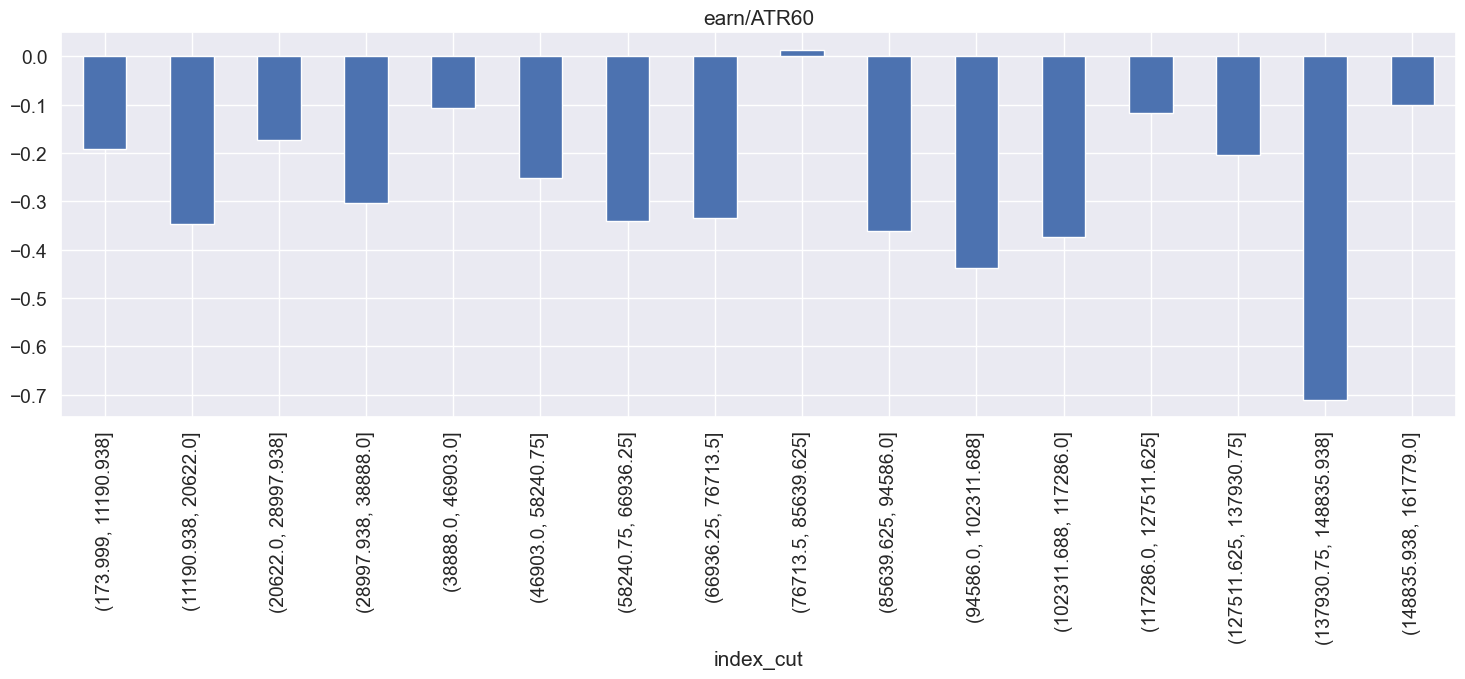

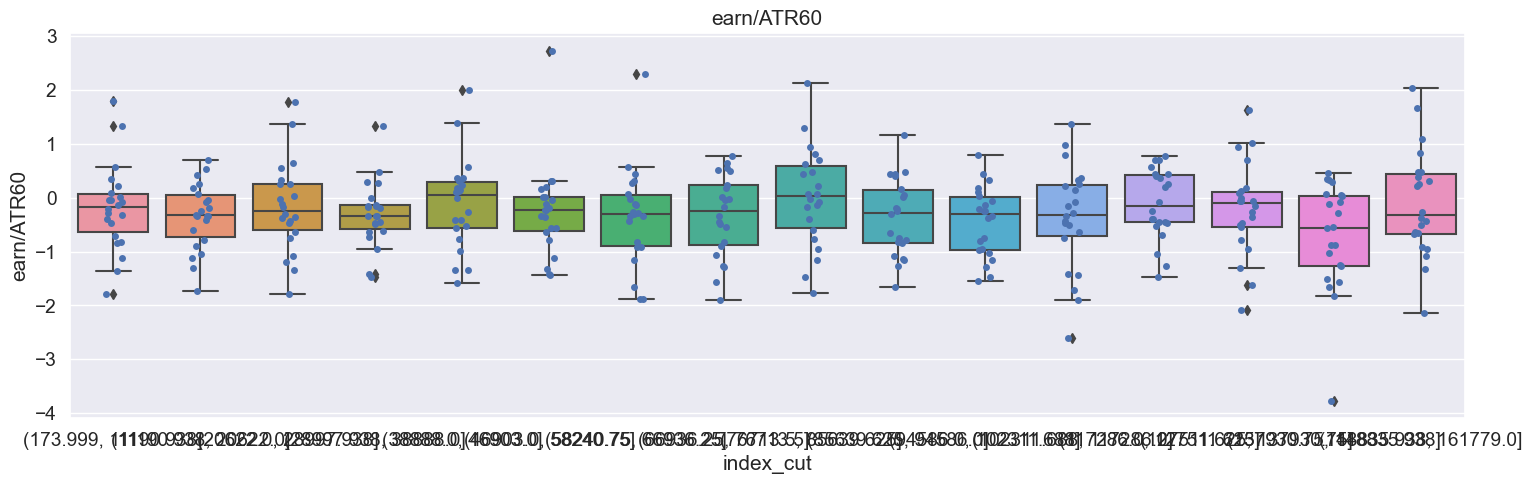

In [281]:
# magic_data = heatmap_data.loc[:500].copy()
magic_data = heatmap_data.copy()

# Bad condition
# - low aerabs60
b_aerabs_cond = (magic_data['AERabs21'] < 0.43) & (magic_data['AERabs60'] < 0.41) & (magic_data['MA3'] < -0.3) & (magic_data['close'] < -0.18)
# - low aer11
b_aer11_cond = (magic_data['AER11'] < 0.03) & (magic_data['MA10_inc10'] < 1.7) & (
    (magic_data['open'] > 0.5) | (magic_data['open'] < 0.2))
# - ATR60 is too low
b_atr60_cond = (magic_data['ATR60'] < 0.0003) & (magic_data['std10abs10'] < 1)
# - low range around ma 10, i.e. No large range around ma.
b_std10abs_cond = ((magic_data['std10abs10'] < 0.3) & (magic_data['std10abs60'] < 0.8)) | (magic_data['std10abs60'] < 0.55)
# - Cycle step
b_cycle_step_cond = ((magic_data['cycle_step'] == 1) & (magic_data['ATR10'] > 0.82) & (magic_data['MA10'] < -0.2) & 
                    ~((magic_data['2step_inc'] > 1.05) & (magic_data['high'] < 0.175) & (magic_data['low'] < -0.74)))   # (magic_data['E/V'] > 1.00) & 
                    # ((magic_data['E/V'] > 1.00) & (magic_data['high'] < 0.175) & (magic_data['low'] < -0.54)))
# - MA60 inc 10
b_ma60_inc10_cond = ((magic_data['MA60_inc10'] < -0.08) & (magic_data['MA10'] < -1.3) & 
                     ((magic_data['MA60'] > -1.5) | (magic_data['top-bottom/step'] < 1.3)) & (magic_data['MA60'] < 3))

# Good condition
# - TR change a lot in latest 20 cycle
g_atrstd20_cond = ((magic_data['ATRstd20'] > 0.75) & ((magic_data['close'] < -1.8) | (magic_data['ATRstd20'] > 1.05)) &
                   (magic_data['close'] < -0.3) & (magic_data['AER11'] < 0.2) & (magic_data['top-bottom/step'] > 0.75))
# - high aerabs60
g_aerabs60_cond = ((magic_data['AERabs60'] > 0.48) & (magic_data['MA10_inc10'] > -0.95) & (magic_data['ATRstd20'] > 0.33) & 
                   (magic_data['AER11'] < 0.16) & (magic_data['ll_top'] > -2.4))
# - 2 step increase
g_2step_inc_cond = (magic_data['2step_inc'] < 0.2) & (magic_data['btm_step/top_step'] < 0.67)
# - ll top is high
g_ll_top_cond = (magic_data['ll_top'] > 2.5) & ((magic_data['AER11'] > -0.01) | ((magic_data['close'] > -0.5) & 
                ((magic_data['std10'] < -1.5) | ((magic_data['top-bottom/step'] > 0.5) & (magic_data['close'] < -0.19)))))
# - Increase not too fast and top is not high
g_ma3_cond = ((magic_data['MA3'] > -0.45) & (magic_data['std10abs60'] > 0.7) &
              ((magic_data['cycle_step'] >= 3) | (magic_data['close'] > -0.13)))
# - Cycle step 
g_cycle_step_cond = ((magic_data['cycle_step'] == 1) & (((magic_data['MA10_inc10'] > 1.6) & (magic_data['open'] > -0.57)) |
                     ((magic_data['AERabs21'] < 0.38) & (magic_data['ATRstd20'] < 0.374) & (magic_data['ATRstd60'] > 0.46))))


bad_cond = (b_aerabs_cond | b_aer11_cond | b_atr60_cond | b_std10abs_cond | b_ma60_inc10_cond)
good_cond = (g_atrstd20_cond | g_aerabs60_cond | g_2step_inc_cond | g_ll_top_cond | g_ma3_cond | g_cycle_step_cond)
magic_data = magic_data[(~bad_cond & (~good_cond)) & b_cycle_step_cond]

magic_data['index'] = magic_data.index

log_earn(magic_data)

Too high

In [15]:
# magic_data = heatmap_data.copy()
# magic_data['ll_l_bottom'] = magic_data['ll_bottom'] - magic_data['last_bottom']

# aer10_cond = (magic_data['AER10'] > 0.15)
# ma60_comd = (magic_data['MA60'] < -1) | (magic_data['MA60'] > 0)

# top_cond = magic_data['last_top'] > 1
# ll_top_cond = magic_data['ll_top'] < 0

# open_cond = magic_data['open'] < 0
# high_cond = magic_data['high'] < 0.6

# is_up_cond = magic_data['is_up'] == 0

# cycle_step_cond = (magic_data['cycle_step'] < 3.5) | (magic_data['cycle_step'] > 6.5)

# ll_l_bottom_cond = magic_data['ll_l_bottom'] < 0.2

# ma3_cond = magic_data['MA3'] < 0

# # magic_data = magic_data[(is_up_cond | ma3_cond) & ma60_comd & open_cond & top_cond & high_cond & ll_top_cond & cycle_step_cond & ll_l_bottom_cond]
# magic_data = magic_data[(is_up_cond | ma3_cond) & ma60_comd & open_cond & top_cond & high_cond & ll_top_cond & cycle_step_cond & ll_l_bottom_cond]


# log_earn(magic_data)

In [16]:
# magic_data = heatmap_data[~cond_low_er].copy()

# _2step_inc_cond = magic_data['2step_inc'] > 0.8

# last_top_cond = magic_data['last_top'] > 0.5
# last_bottom_cond = magic_data['last_bottom'] > -1

# ma60_cond = magic_data['MA60'] > -0.4
# er60_cond = magic_data['AER60'] < 0.1
# std10_cond = magic_data['std10'] < -0.2

# # magic_data = magic_data[_2step_inc_cond & last_bottom_cond & last_top_cond & ma60_cond & er60_cond & std10_cond]

# log_earn(magic_data)

e:\Python\Lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
e:\Python\Lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


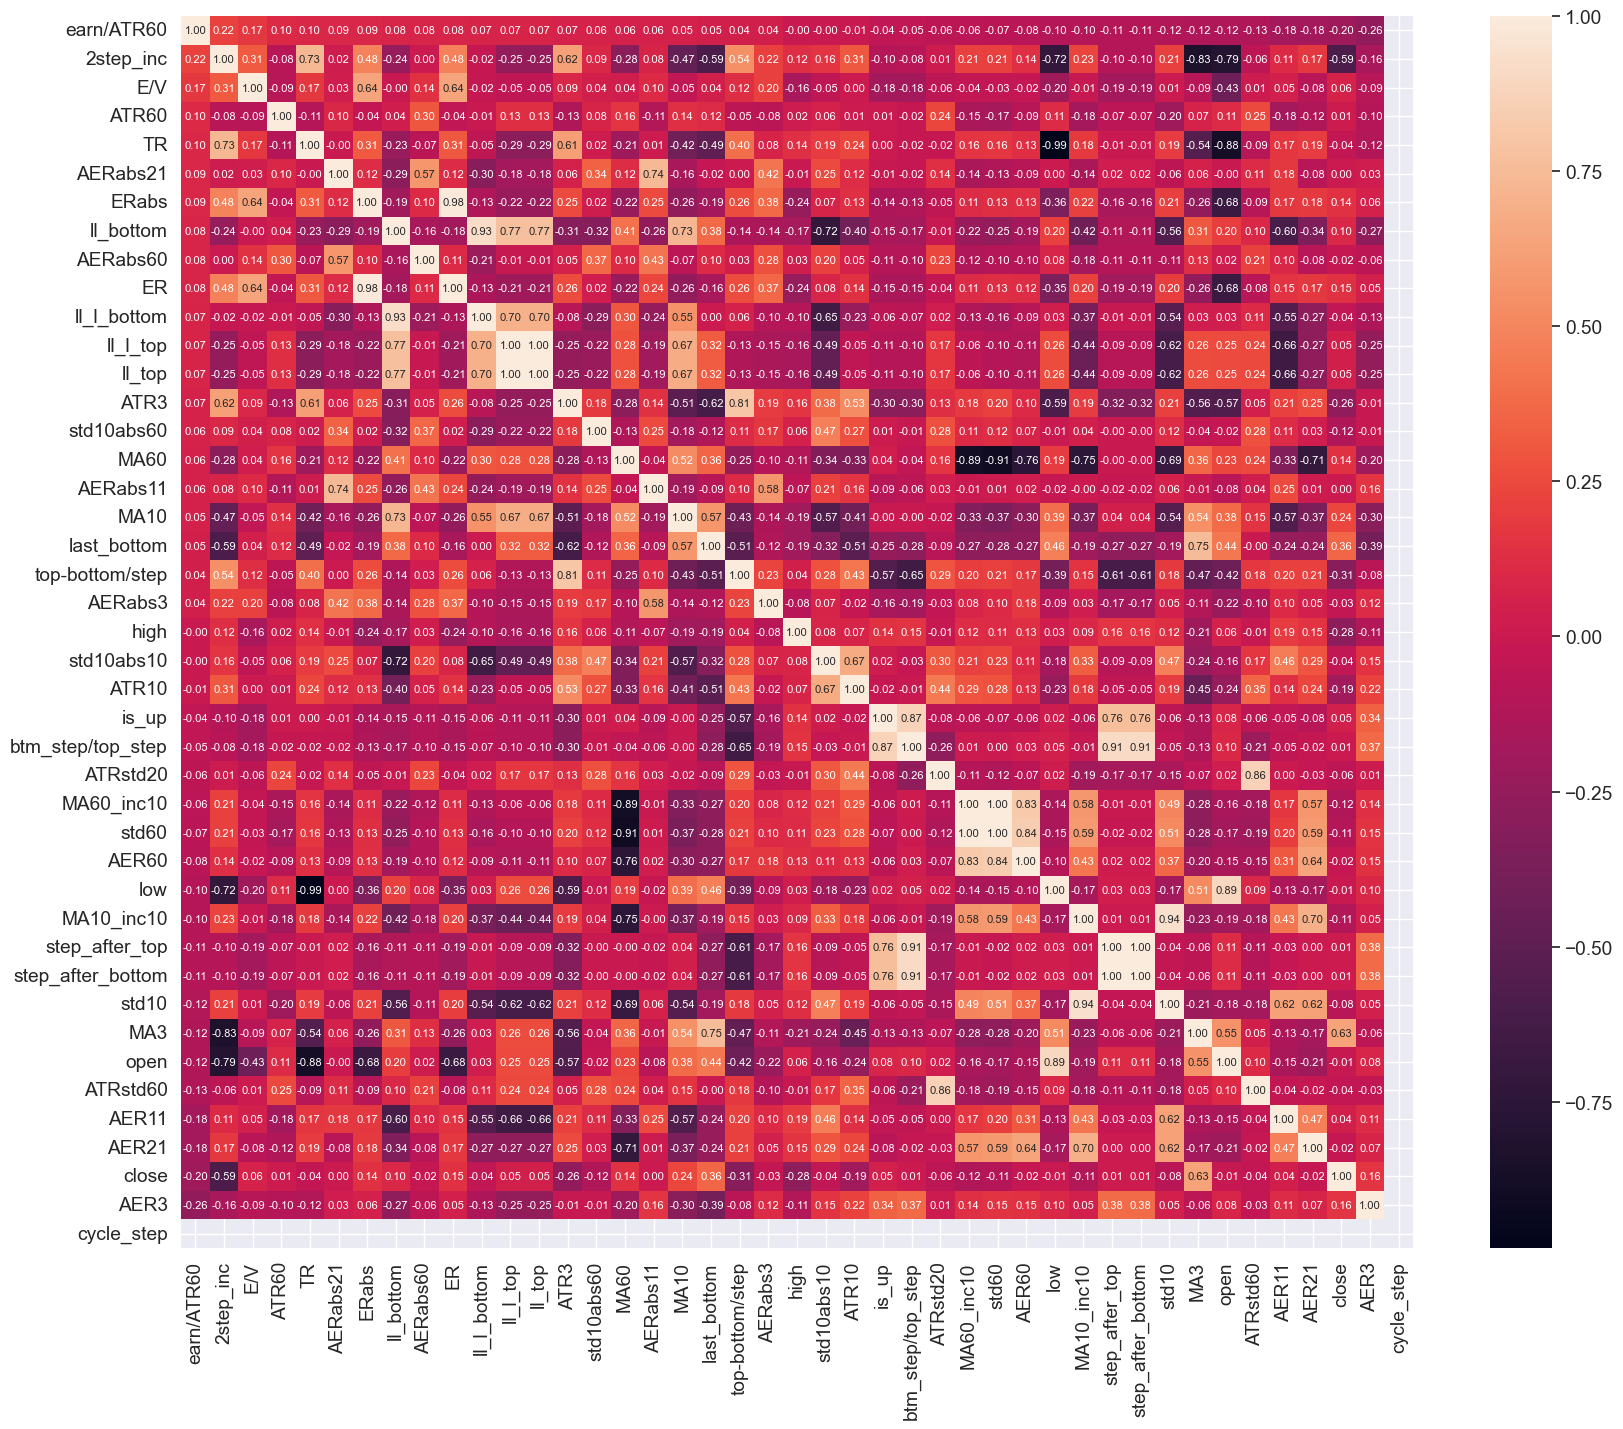

In [264]:
# ma10_data = heatmap_data[ma10_cond & top_cond & ll_bottom_cond].loc[:, :].copy()
heatmap_font(magic_data.loc[:, cols], target_name)

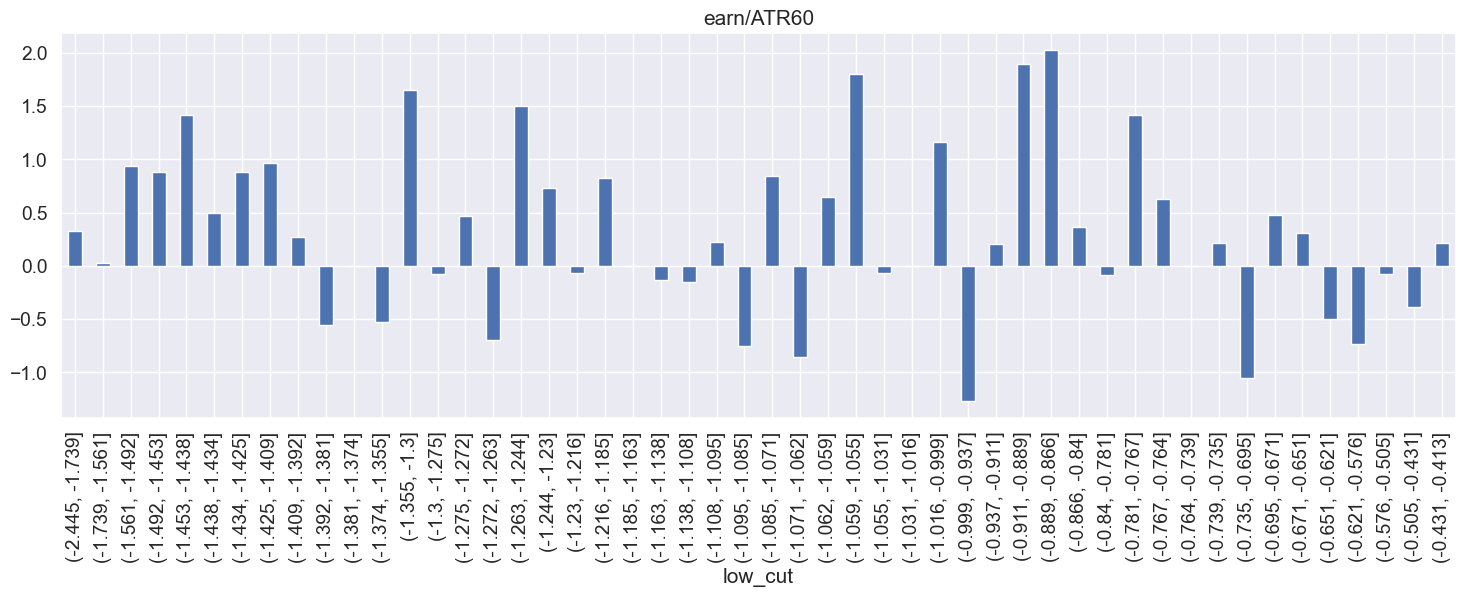

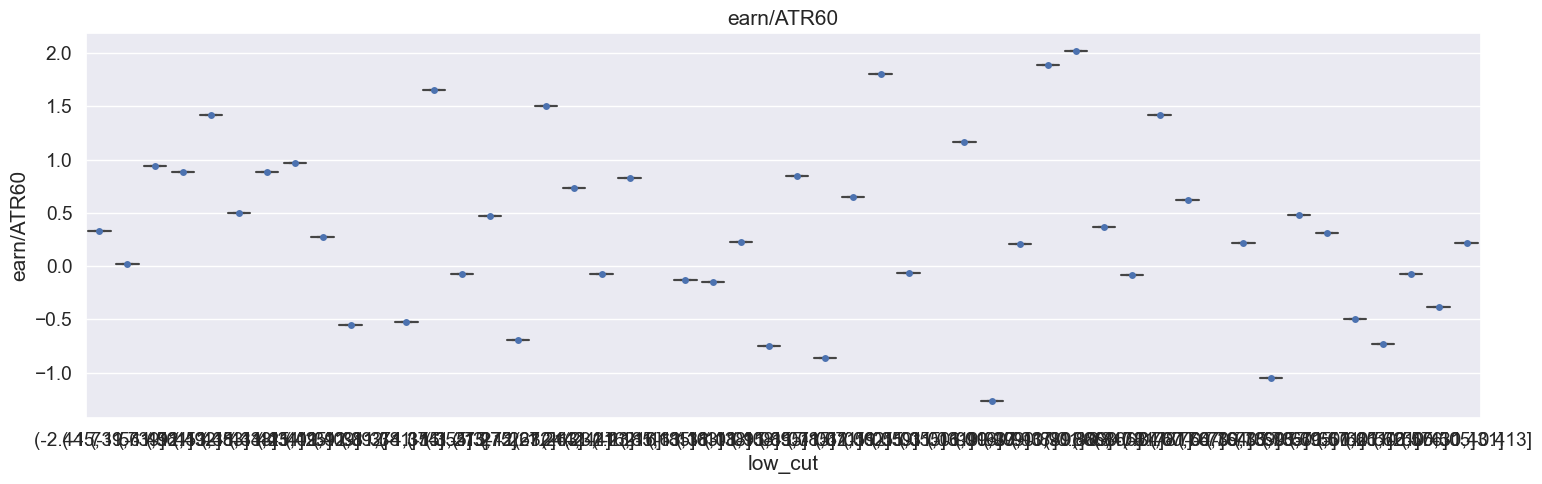

In [277]:
# checked = 'is_up'
# checked = 'open'
checked = 'low'
# checked = 'high'
# checked = 'close'
# checked = 'btm_step/top_step'
# checked = 'step_after_top'
# checked = 'step_after_bottom'
# checked = 'cycle_step'
# checked = 'ER'
# checked = 'ERabs'
# checked = 'E/V'
# checked = 'AER3'
# checked = 'AER11'
# checked = 'AER21'
# checked = 'AER60'
# checked = 'AERabs3'
# checked = 'AERabs11'
# checked = 'AERabs21'
# checked = 'AERabs60'
# checked = 'MA3'
# checked = 'MA10'
# checked = 'MA60'
# checked = 'MA10_inc10'
# checked = 'MA60_inc10'
# checked = 'signal_ER'
# checked = 'histogram_close'
# checked = 'std10'
# checked = 'std60'
# checked = 'std10abs10'
# checked = 'std10abs60'
# checked = 'ATRstd20'
# checked = 'ATRstd60'
# checked = 'ATR60'
# checked = 'ATR10'
# checked = 'ATR3'
# checked = 'TR'
# checked = 'last_bottom'
# checked = 'll_top'
# checked = 'll_l_top'
# checked = 'll_bottom'
# checked = 'll_l_bottom'
# checked = '2step_inc'
# checked = 'top-bottom/step'

# plot_data = heatmap_data[(heatmap_data['MA3'] > 0) & (heatmap_data['MA3'] < -0.202)].loc[:, :].copy()
# plot_data = heatmap_data[ma10_cond].loc[:, :].copy()
# plot_data = heatmap_data.iloc[:, :].copy()
plot_data = magic_data.copy()
# plot_data = magic_data[magic_data[checked] <= -1.5].copy()

plot_data['index'] = plot_data.index
bias = 0

# plt_A_B(plot_data, 'index', 'ATR10', cut_num=10)
# plt_A_B(plot_data, 'index', 'earn/ATR10', cut_num=10)
# plt_A_B(plot_data, 'index', 'ATR10', cut_num=10)

# plt_A_B(plot_data, 'index', checked, cut_num=10, bias=bias)
# plt_box_A_B(plot_data, 'index', checked, cut_num=50)

plt_A_B(plot_data, checked, target_name, cut_num=50)
plt_box_A_B(plot_data, checked, target_name, cut_num=50)
# histplot(plot_data[checked])
# sns.set()
# cols = ['ATR3','AERabs10', target_name]
# sns.pairplot(plot_data[cols], height = 2.5)
# plt.show()

In [192]:
# plot_data[(plot_data[checked] > 0.69) & (plot_data[checked] < 0.76)]
# plot_data[(plot_data[checked] > 0)]
plot_data[(plot_data[target_name] > 4)]

,open,high,low,close,TR,step_after_top,last_bottom,step_after_bottom,is_up,cycle_step,earn,is_earn,ER,ERabs,2step_inc,top-bottom/step,btm_step/top_step,ll_top,ll_bottom,ll_l_top,ll_l_bottom,E/V,MA3,MA10,MA60,ATR3,ATR10,ATR60,AER3,AER11,AER21,AER60,AERabs3,AERabs11,AERabs21,AERabs60,ATRstd60,ATRstd20,std10,std60,std10abs10,std10abs60,MA10_inc10,MA60_inc10,earn/ATR60,index
15646,-0.293691,0.128953,-0.346136,-0.090699,0.475089,15.0,-2.896807,7.0,1.0,8.0,0.003656,1,0.667532,0.667532,0.407836,0.362101,0.466667,0.230140,-1.169829,0.230140,1.726978,0.282103,-0.296570,-0.795126,0.638398,0.990282,0.935678,0.000587,0.293624,0.115169,0.000923,-0.060990,0.306072,0.242454,0.317866,0.387746,0.500850,0.344579,0.154391,-0.369980,0.438334,0.575138,-0.084590,-0.948861,6.229337,15646
37741,-0.180020,0.252847,-0.361677,-0.252847,0.614524,2.0,-0.614524,0.0,0.0,2.0,0.002179,1,0.419441,0.419441,0.510603,0.614524,0.000000,-0.914013,-1.362427,-0.914013,-0.747903,0.371010,-0.296215,-0.503403,-2.034422,0.753086,0.695943,0.000456,0.226315,0.072032,0.121396,0.129002,0.635169,0.486799,0.402131,0.406443,0.402159,0.302825,0.270914,0.300305,0.358617,0.706827,0.814183,0.684869,4.773729,37741


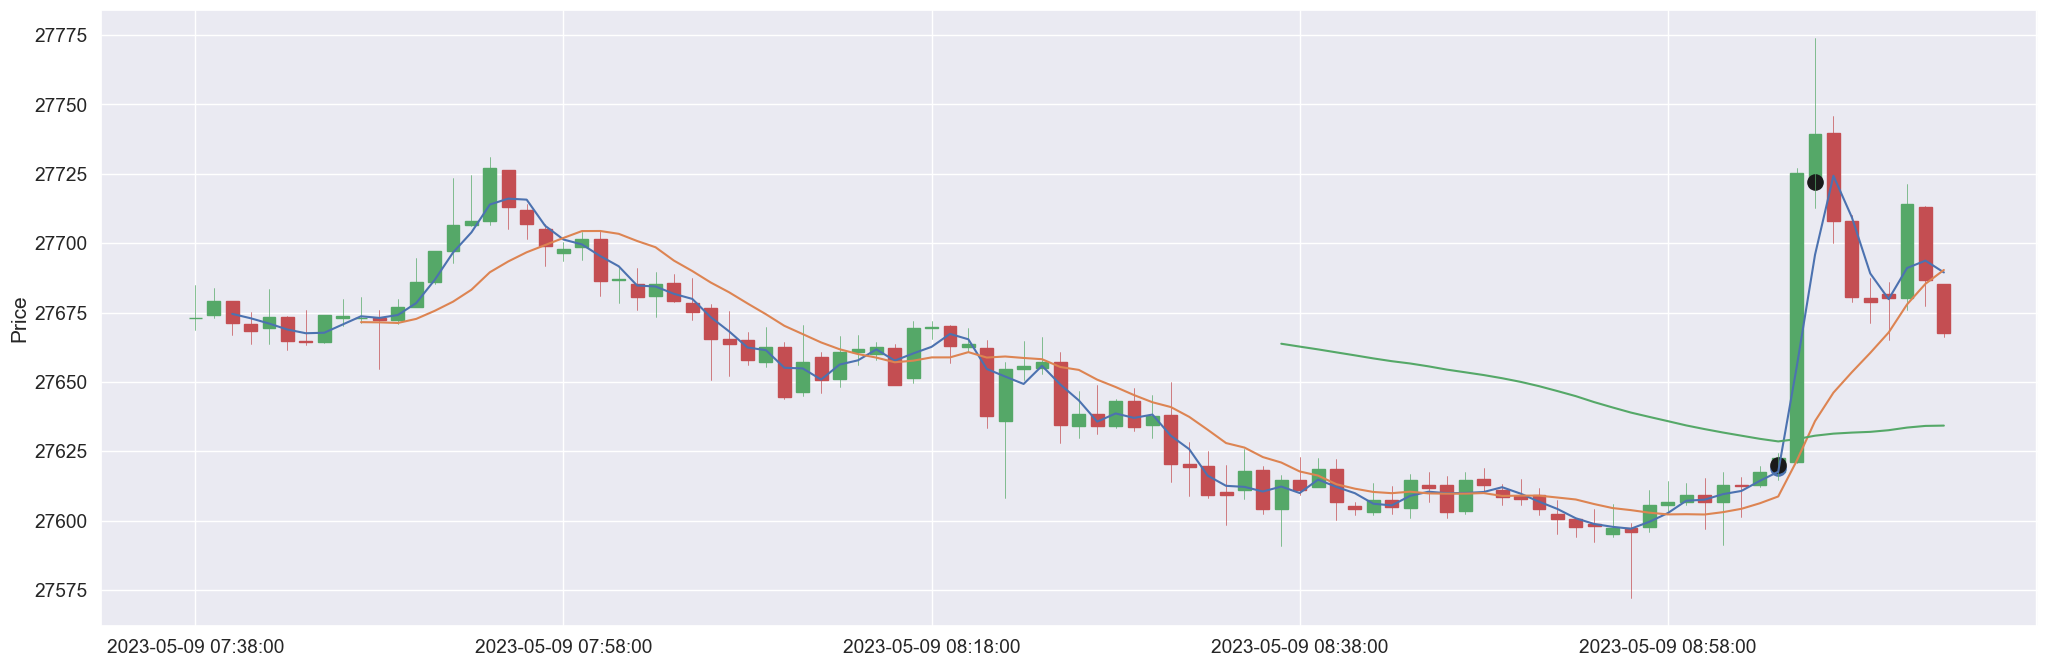

In [195]:
# idx = heatmap_data[(heatmap_data['high'] > 0.4)].index
# print(len(idx))
start = 15646			 # magic_data.index[0]      
# print(f"high: {heatmap_data.loc[start, 'earn/ATR60']}")
last_top_idx = start - sim_data.loc[start, 'step_after_top']
sell_idx = sim_data.loc[start, 'hold_step'] + start + 1
points = [PricePlot.Points(start+1, sim_data.loc[start, 'last_top'], s=120, c='b', label='default'),
          PricePlot.Points(sell_idx, sim_data.loc[start, 'sell_price'], s=120, c='k', label='default'),
          PricePlot.Points(start+1, sim_data.loc[start, 'buy_price'], s=120, c='k', label='default')]
plot(sim_data, last_top_idx-70, start+10, points, mas=[3, 10, 60])

In [ ]:
heatmap_data[heatmap_data['AER10'] > 0.4]

,open,high,low,TR,last_top,step_after_top,last_bottom,step_after_bottom,cycle_step,hold_step,earn,is_earn,max_after_top,min_after_top,ER,lastlast_top,lastlast_bottom,MA3,MA10,MA60,MA300,ATR3,ATR10,ATR60,ATR300,AER3,AER10,AER60,AER300,earn/ATR10,ave_after_top
5916,-0.563238,0.180649,-0.563238,0.743908,0.310866,3.0,-4.844257,10.0,7.0,14.0,-0.002572,0,0.000109,-0.002011,0.757134,-4.303962,-4.844257,-0.537883,-2.321593,-4.985972,-6.510988,1.188848,0.001714,0.402675,0.246243,0.250085,0.448643,0.050170,0.017125,-1.500844,-0.000951
16422,0.093853,0.608970,-0.320963,0.930004,0.645508,3.0,-4.475570,10.0,7.0,2.0,0.000233,1,0.000271,-0.000261,-0.100917,-2.223814,-4.475570,0.031762,-1.056455,-1.341166,13.861365,0.734656,0.000465,1.267051,1.528524,0.044293,0.405142,0.017114,-0.002235,0.501039,0.000005
18077,-1.288129,0.169988,-1.290018,1.460100,2.993673,27.0,-5.116630,9.0,18.0,0.0,0.000179,1,0.000376,-0.001230,0.882220,2.993673,-5.116630,-1.138918,-3.221645,-3.219300,-11.691305,1.420122,0.000358,1.492791,1.565049,0.858768,0.432478,0.089521,0.064085,0.501350,-0.000427
36032,-0.331741,0.143300,-0.542229,0.685581,0.478715,13.0,-4.922051,9.0,4.0,0.0,0.000322,1,0.000693,-0.000060,0.483883,0.478715,-4.922051,-0.530856,-2.052753,-1.075044,-9.517801,1.026945,0.000642,1.481917,1.475424,0.419707,0.400749,0.008395,0.042138,0.500752,0.000316
36944,-0.987664,0.000757,-1.142057,1.142890,0.267918,15.0,-5.133581,10.0,5.0,0.0,0.000233,1,0.000239,-0.001075,0.864181,0.267918,-5.133581,-0.647342,-1.741240,2.511163,-10.945241,0.826787,0.000465,1.139623,1.374061,0.142713,0.447838,-0.072717,0.029505,0.501037,-0.000418
71254,-0.279886,0.212871,-0.393220,0.606189,0.477974,5.0,-5.529713,12.0,7.0,0.0,0.000194,1,0.000343,-0.000418,0.461714,0.477974,-5.529713,-0.415229,-1.187642,-2.293683,-0.395605,0.851582,0.000387,1.380572,1.908390,0.285357,0.404085,0.041236,-0.008251,0.501242,-0.000037


# ML

In [17]:
import xgboost as xgb
from sklearn.model_selection import KFold
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [18]:
def split_data(full: pd.DataFrame, percentage=0.8, target_name='target'):
    # 特征列名
    category_col = [col for col in full if col != target_name]
    end_rows = int(full.shape[0] * percentage)

    x_train = full[category_col][:end_rows].values.astype(np.float64)
    y_train = full[target_name][:end_rows].values.astype(np.float64)

    x_test = full[category_col][end_rows:].values.astype(np.float64)
    y_test = full[target_name][end_rows:].values.astype(np.float64)

    return x_train, y_train, x_test, y_test

ML_data = heatmap_data.loc[:, cols].copy()
x_train, y_train, x_test, y_test = split_data(ML_data, 0.8, target_name)

In [21]:
def xgb_predict(X_train, y_train, X_test, params=None, verbose_eval=100):
    
    if params == None:
        xgb_params = {'eta': 0.05, 'max_depth': 5, 'subsample': 0.8, 'colsample_bytree': 0.8, 
                  'objective': 'reg:linear', 'eval_metric': 'rmse', 'nthread': 4}
    else:
        xgb_params = params

    folds = KFold(n_splits=3, shuffle=True, random_state=2023)
    oof_xgb = np.zeros(len(X_train))
    predictions_xgb = np.zeros(len(X_test))

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
        if(verbose_eval):
            print("fold n°{}".format(fold_+1))
            print("len trn_idx  {}".format(len(trn_idx)))
            
        trn_data = xgb.DMatrix(X_train[trn_idx], y_train[trn_idx])
        val_data = xgb.DMatrix(X_train[val_idx], y_train[val_idx])

        watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
        clf = xgb.train(dtrain=trn_data,
                        num_boost_round=20000,
                        evals=watchlist,
                        early_stopping_rounds=200,
                        verbose_eval=verbose_eval,
                        params=xgb_params)
        
        
        oof_xgb[val_idx] = clf.predict(xgb.DMatrix(X_train[val_idx]), ntree_limit=clf.best_ntree_limit)
        predictions_xgb += clf.predict(xgb.DMatrix(X_test), ntree_limit=clf.best_ntree_limit) / folds.get_n_splits()

    if(verbose_eval):
        print("CV RMSE score: {:<8.8f}".format(sqrt(mean_squared_error(oof_xgb, y_train))))
    return oof_xgb, predictions_xgb

In [22]:
oof, predictions = xgb_predict(x_train, y_train, x_test, verbose_eval=5000)

print("-"*100, end="\n\n")
print("CV normal RMSE scores of predicting {} \nis {:<8.8f}".
        format(ML_data.columns, sqrt(mean_squared_error(predictions, y_test))))

fold n°1
len trn_idx  3685
[21:31:25] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:1.06091	valid_data-rmse:1.05348


[228]	train-rmse:0.60510	valid_data-rmse:1.01008
fold n°2
len trn_idx  3685
[21:31:27] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:1.06197	valid_data-rmse:1.05388


e:\Python\Lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[237]	train-rmse:0.61128	valid_data-rmse:0.97461
fold n°3
len trn_idx  3686
[21:31:29] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:1.05171	valid_data-rmse:1.07461
[234]	train-rmse:0.59287	valid_data-rmse:1.01036
CV RMSE score: 0.97571854
----------------------------------------------------------------------------------------------------

CV normal RMSE scores of predicting Index(['open', 'high', 'low', 'TR', 'last_top', 'step_after_top',
       'last_bottom', 'step_after_bottom', 'is_up', 'cycle_step', 'ER',
       'ERabs', '2step_inc', 'top-bottom/step', 'll_top', 'll_bottom',
       'll_l_top', 'll_l_bottom', 'E/V', 'MA3', 'MA10', 'MA60', 'ATR3',
       'ATR10', 'ATR60', 'AER3', 'AER10', 'AER20', 'AER60', 'AERabs3',
       'AERabs10', 'AERabs20', 'AERabs60', 'std10', 'std10abs', 'MACD_ER',
      

In [23]:
print(np.std(y_test))
print(np.mean(y_test))
pred_std, pred_mean = [np.std(predictions), np.mean(predictions)]
print(pred_std)
print(pred_mean)

0.9478452570060517
0.07564353254166338
0.13287514193964156
0.13872867592816535


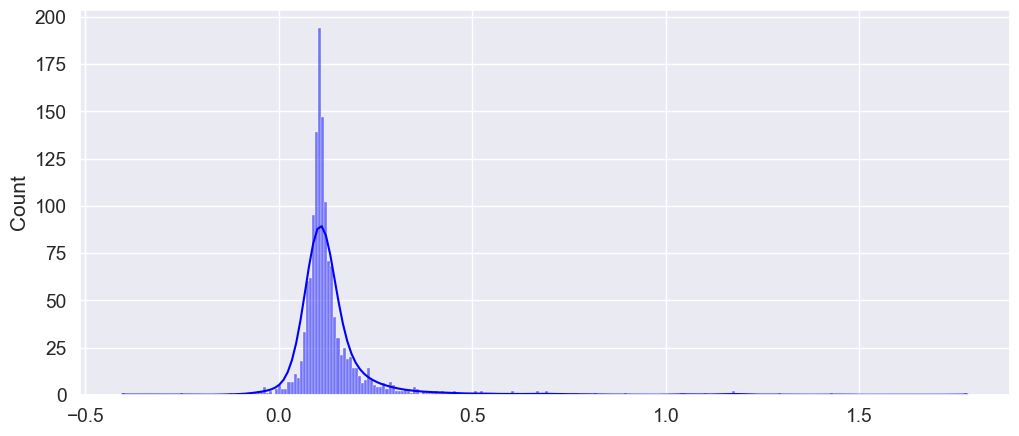

In [24]:
histplot(predictions)

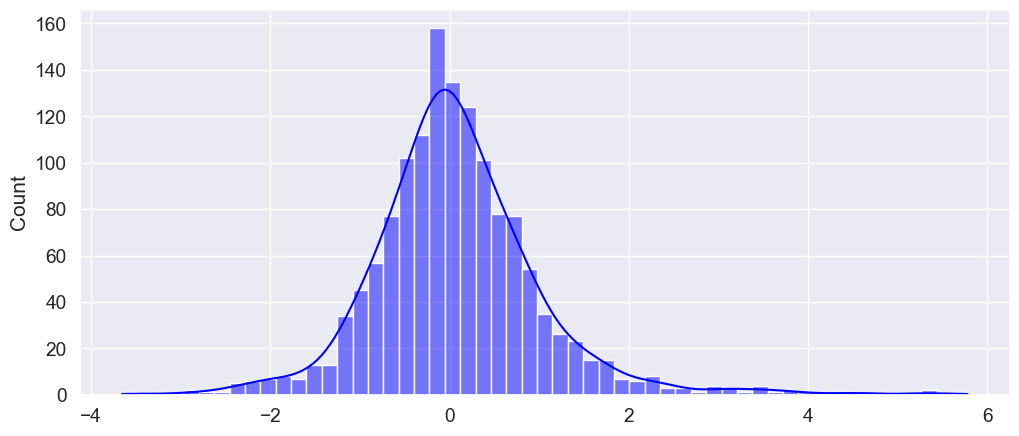

In [25]:
histplot(y_test)

In [26]:
buy_i = [i for i in range(len(y_test)) if predictions[i] > 0.5] 
sell_i = [i for i in range(len(y_test)) if predictions[i] < 0]
print(len(buy_i))
print(len(sell_i))
buy_i

31
20


[93,
 143,
 209,
 343,
 344,
 366,
 381,
 400,
 458,
 498,
 577,
 617,
 627,
 633,
 658,
 660,
 729,
 738,
 756,
 936,
 1083,
 1126,
 1153,
 1237,
 1326,
 1339,
 1352,
 1356,
 1367,
 1368,
 1369]

In [ ]:
x_test[1153]

array([ 2.00704540e+00,  2.09630252e+00, -8.05793398e-01,  2.90209598e+00,
        3.18536329e+00,  2.00000000e+00, -8.05793398e-01,  0.00000000e+00,
        0.00000000e+00,  2.00000000e+00, -7.34087981e-01,  4.16719155e+00,
        6.65089474e-01,  9.81828264e-01,  1.47088287e+00,  1.35414614e+00,
        1.89342853e+00, -9.91415139e-01,  1.61303315e+00,  1.44844469e+00,
        5.17689858e-04, -1.28518474e-01,  4.61356161e-02,  9.04500024e-02,
        4.12206593e-02,  9.21046648e-01,  1.29973235e+00, -5.45569003e-02,
        1.22369585e-02, -6.67938588e-02])

In [ ]:
ML_data.iloc[len(y_train) + 1153, :]

open                 2.007045
high                 2.096303
low                 -0.805793
TR                   2.902096
last_top             3.185363
step_after_top       2.000000
last_bottom         -0.805793
step_after_bottom    0.000000
is_up                0.000000
cycle_step           2.000000
ER                  -0.734088
ll_top               4.167192
ll_bottom            0.665089
ll_l_top             0.981828
ll_l_bottom          1.470883
MA3                  1.354146
MA10                 1.893429
MA60                -0.991415
ATR3                 1.613033
ATR10                1.448445
ATR60                0.000518
AER3                -0.128518
AER10                0.046136
AER30                0.090450
AER60                0.041221
std10                0.921047
std10abs             1.299732
MACD_ER             -0.054557
signal_ER            0.012237
histogram_ER        -0.066794
earn/ATR60           1.861287
Name: 96318, dtype: float64

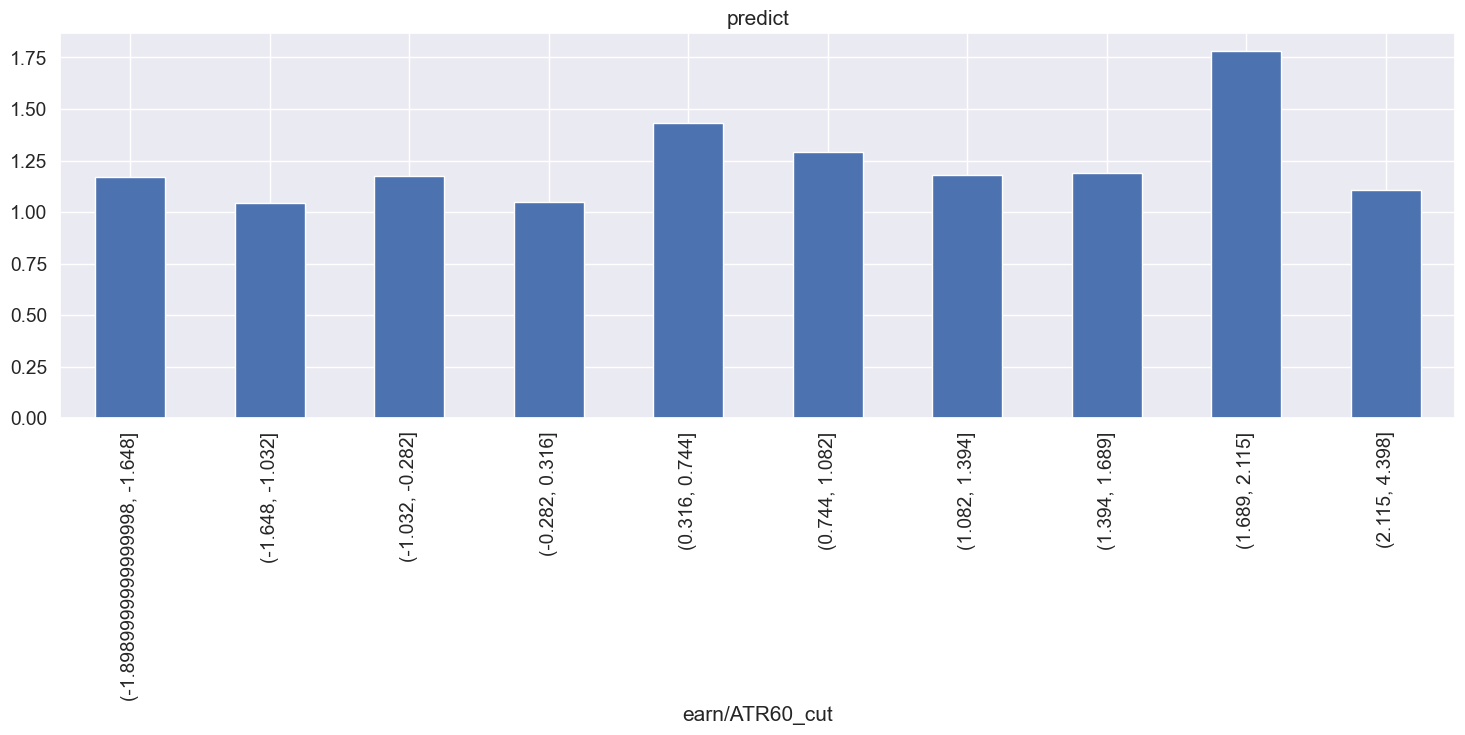

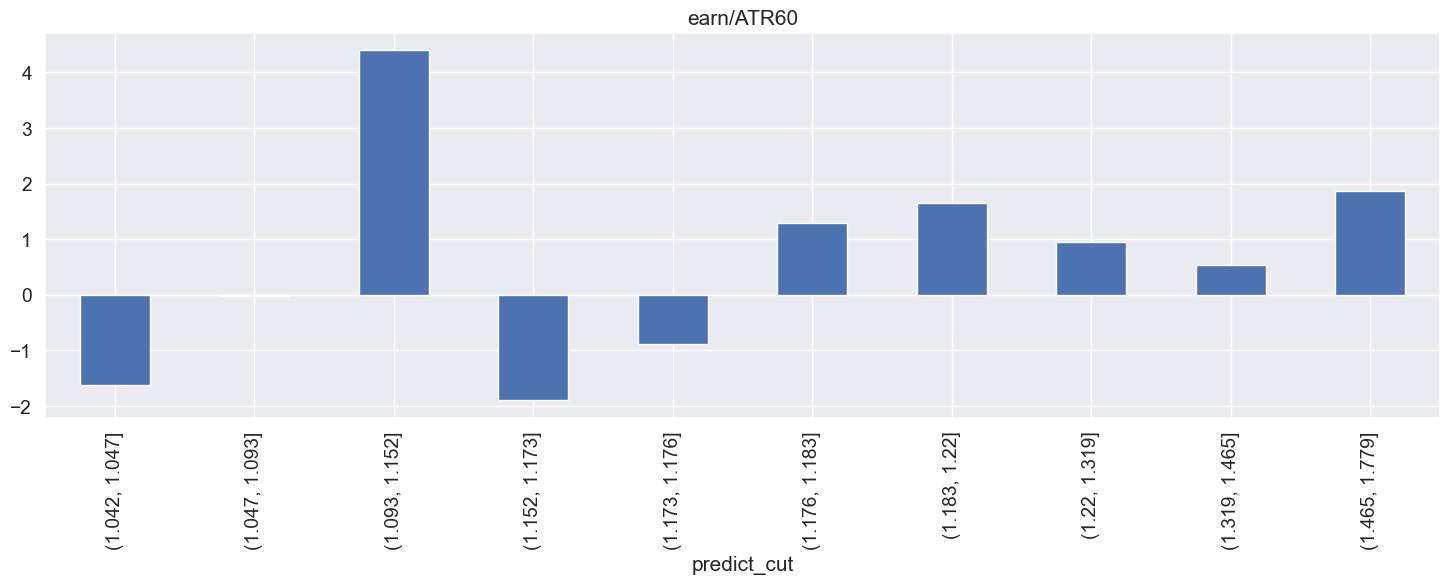

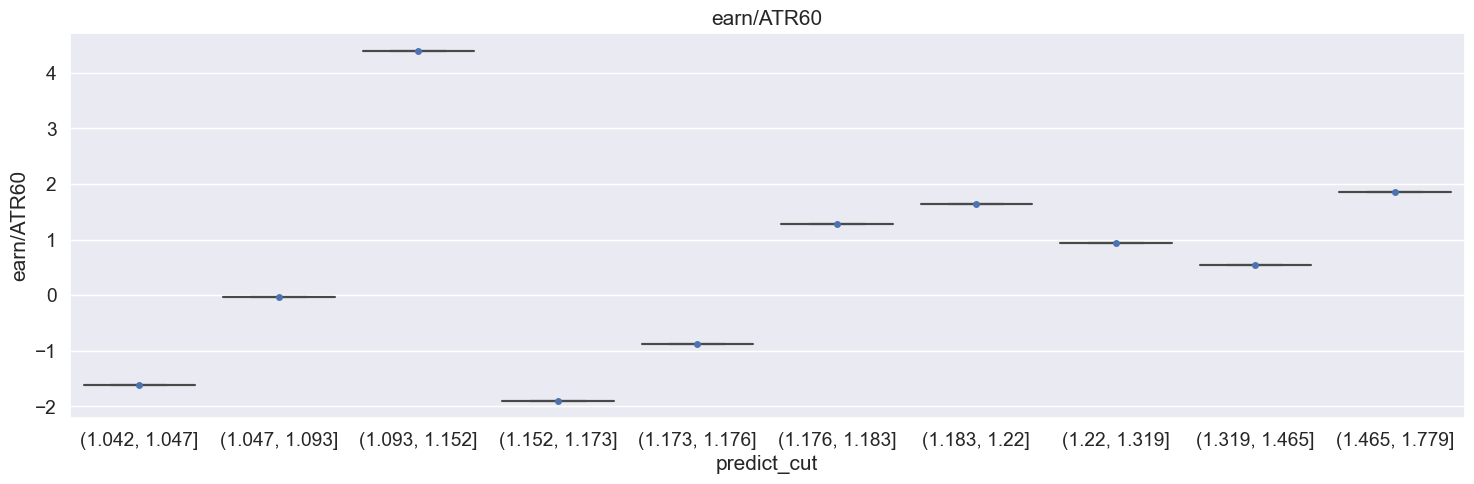

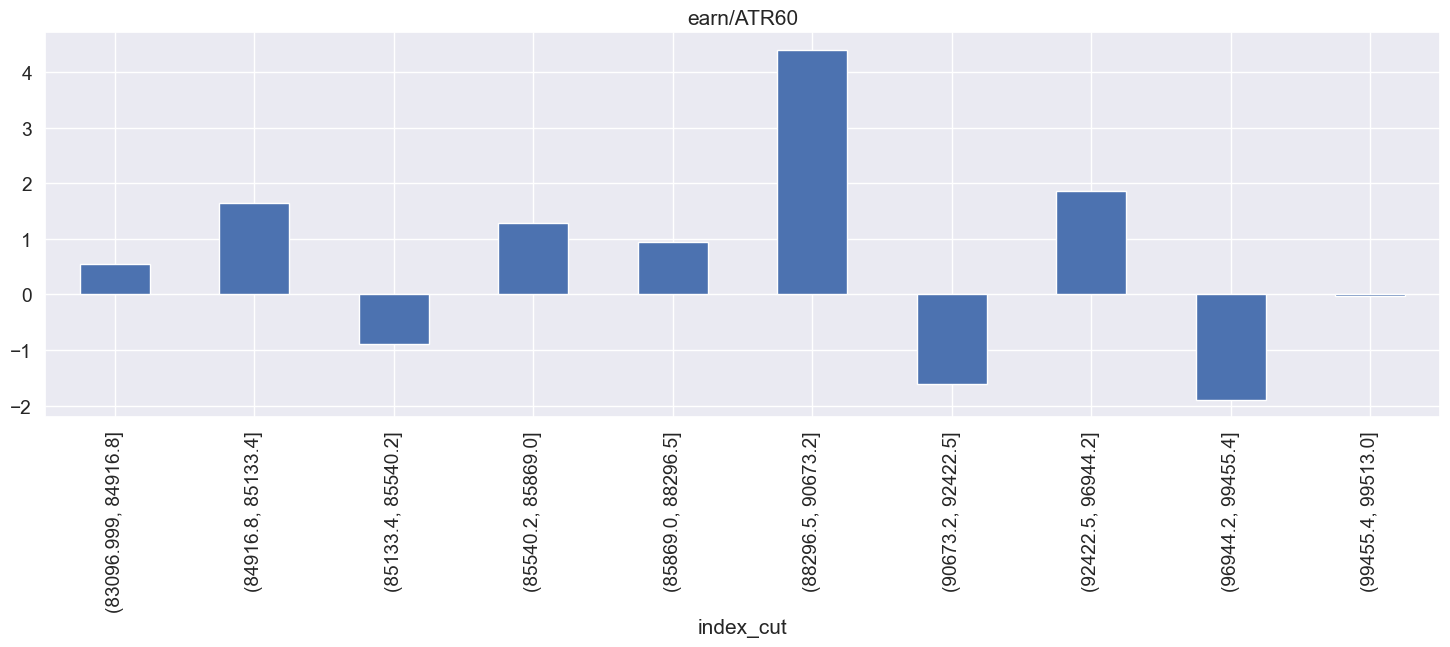

In [31]:
test_df = ML_data.iloc[len(y_train):, :].copy()
test_df['predict'] = predictions
test_df['index'] = test_df.index

pred_earn = test_df[test_df['predict'] > 1].copy()

plt_A_B(pred_earn, target_name, 'predict', cut_num=10)
plt_A_B(pred_earn, 'predict', target_name, cut_num=10)
plt_box_A_B(pred_earn, 'predict', target_name, cut_num=10)
plt_A_B(pred_earn, 'index', target_name, cut_num=10)
# plt_A_B(test_df, 'index', target_name, cut_num=10)
